# Import Libraries

In [6]:
library(rgdal)
library(gdata)
library(ggplot2)
library(dplyr)
library(lubridate)
library(RColorBrewer)
library(extrafont)
library(stringr)
library(readxl)

In [7]:
# plot options
options(warn=-1, repr.plot.res = 90) # adjust plot size
theme_set(theme_grey(base_family='NanumGothic'))

# Load Data

In [8]:
# 빅콘 - 챔피언스 리그
# ns 홈쇼핑 2019 매출 데이터 및 시청률 데이터 & 2020년 6월 편성표 
hshop.sales <- read_excel("../data/01/2019sales_v2.xlsx")
# hshop.view <- read.xls("../data/00/2019vrating.xlsx", skip = 1, header = TRUE)
hshop.test <- read.xls("../data/00/202006schedule.xlsx", header = TRUE)


New names:
* `` -> ...1


In [10]:
hshop.sales <- as.data.frame(hshop.sales)
colnames(hshop.sales)[1]  <- "index"
hshop.sales$index <- hshop.sales$index + 1

In [6]:

# # define column data type 
# hshop.sales$방송일시 <- as.POSIXct(hshop.sales$방송일시)
# hshop.sales$month <- as.factor(month(hshop.sales$방송일시))
# hshop.sales$day <- as.factor(day(hshop.sales$방송일시))
# hshop.sales$hour <- as.factor(hour(hshop.sales$방송일시))
# hshop.sales$weekday <- factor(weekdays(hshop.sales$방송일시), levels = c("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"))
# hshop.sales$sales <- as.numeric(gsub(",", "", hshop.sales$취급액))
# hshop.sales$판매단가 <- as.numeric(gsub(",", "", hshop.sales$판매단가))
# hshop.sales$volume <- as.numeric(hshop.sales$sales)/as.numeric(hshop.sales$판매단가)

In [7]:
# # drop if sales == 50,000 or null
# dim(hshop.sales) #38309 original
# hshop.sales <- hshop.sales %>%
#   filter(!is.na(sales)) %>%
#   filter(sales != 50000) %>%
#   as.data.frame() #35379 #drop 3,000

[1] 38309    14

In [12]:
colnames(hshop.sales)

[1] "index"        "방송일시"     "노출(분)"     "마더코드"     "상품코드"    
 [6] "상품명"       "상품군"       "판매단가"     "취급액"       "exposed"     
[11] "ymd"          "volume"       "years"        "months"       "days"        
[16] "hours"        "weekdays"     "hours_inweek" "holidays"     "red"         
[21] "weekends"     "min_start"    "japp"         "parttime"     "min_range"   
[26] "show_id"      "primetime"    "sales_power"  "freq"         "men"         
[31] "luxury"       "pay"          "brand"        "original_c"   "small_c"     
[36] "middle_c"     "big_c"

### 월일별 평균 매출 

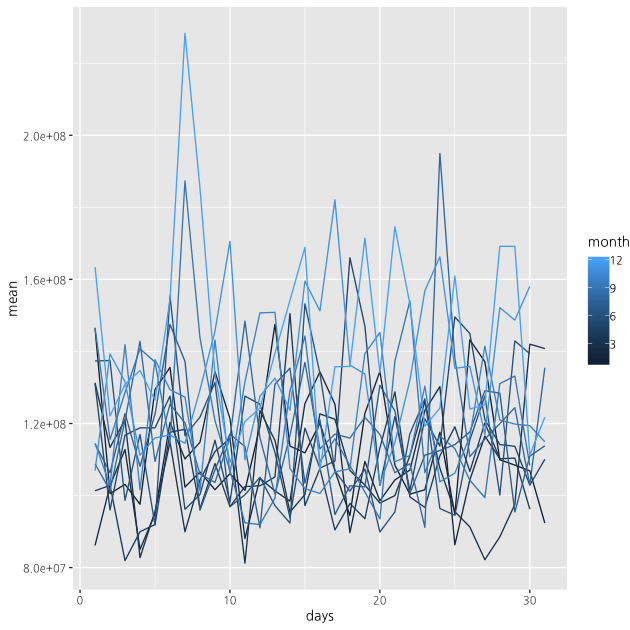

In [28]:
#monthly
md.sales = hshop.sales %>%
  group_by(months, days) %>%
  summarize(mean = sum(취급액)/n_distinct(show_id))
ggplot(md.sales, aes(x=days,y=mean,group=months))+
  geom_line(aes(color = months))

### 요일별 평균매출

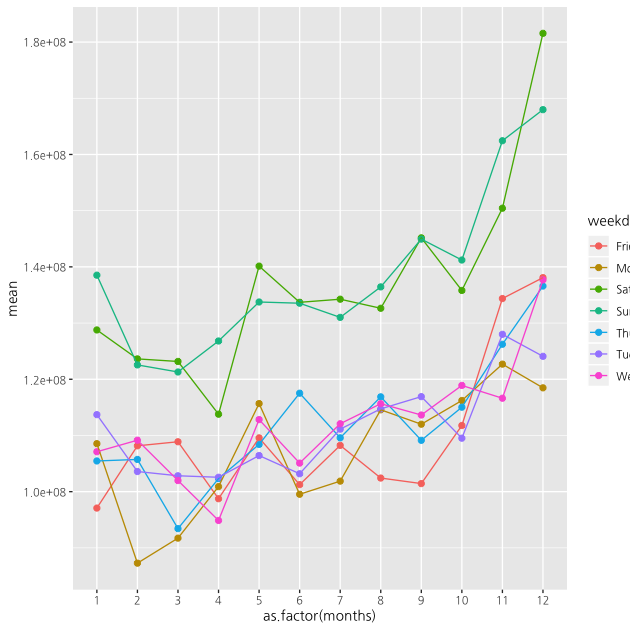

In [23]:
# 기본적으로 주말에 매출량이 많음
# 겨울 정도가 피크

# 평균매출액 기준
hshop.sales %>%
  group_by(months,weekdays) %>%
  summarize(mean=sum(취급액)/n_distinct(show_id)) %>%
  ggplot(aes(x=as.factor(months),y=mean,group=weekdays,color=weekdays)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) 


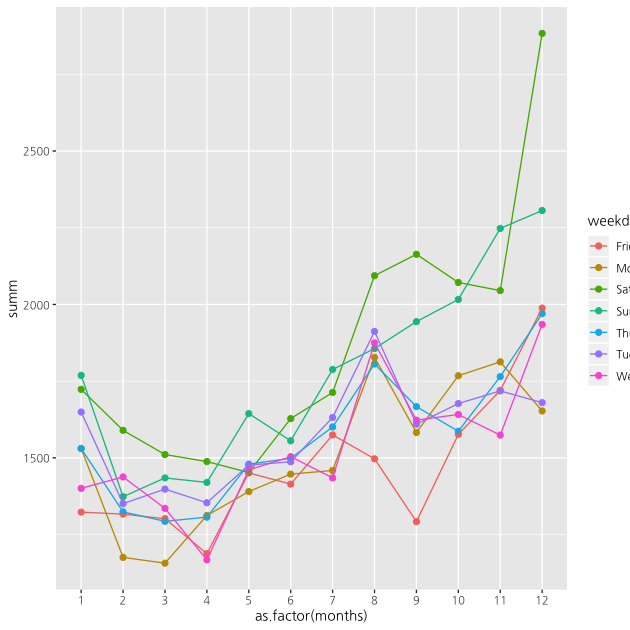

In [24]:
# 판매량합 기준
hshop.sales %>%
  group_by(months,weekdays) %>%
  summarize(summ=sum(volume)/n_distinct(show_id)) %>%
  ggplot(aes(x=as.factor(months),y=summ,group=weekdays,color=weekdays)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) 

### 품목별 월별 판매수량

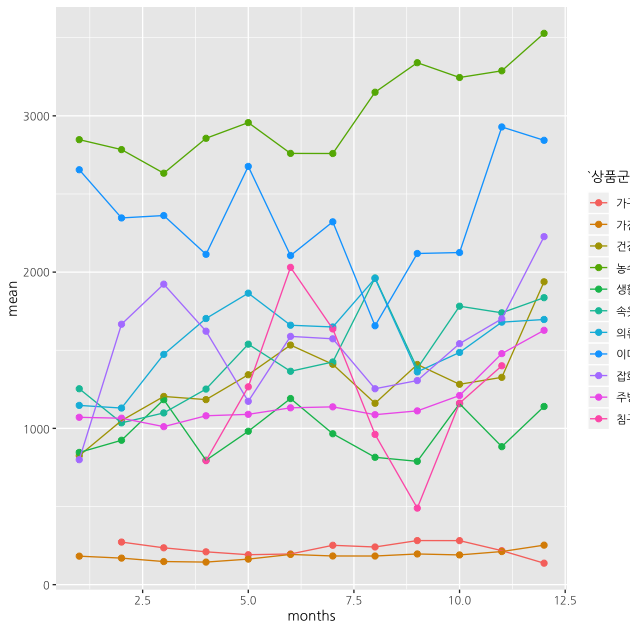

In [30]:
#by category+monthly
hshop.sales %>%
  group_by(상품군, months) %>%
  summarize(mean=sum(volume)/n_distinct(show_id)) %>%
  ggplot(aes(x=months,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5)  


### 평일 시간대별 판매 수량

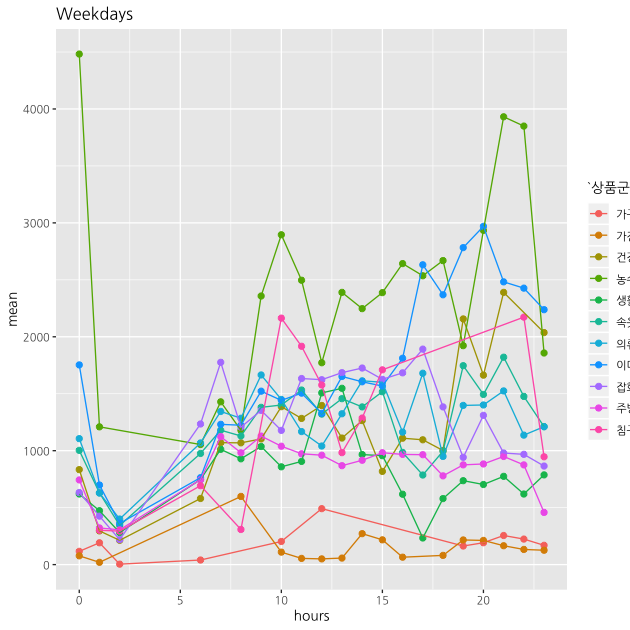

In [31]:
hshop.sales %>%
  filter(weekends != 1) %>%
  group_by(상품군, hours) %>%
  summarize(mean=sum(volume)/n_distinct(show_id)) %>%
  ggplot(aes(x=hours,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) +
  ggtitle("Weekdays")

### 주말 시간대별 판매 수량

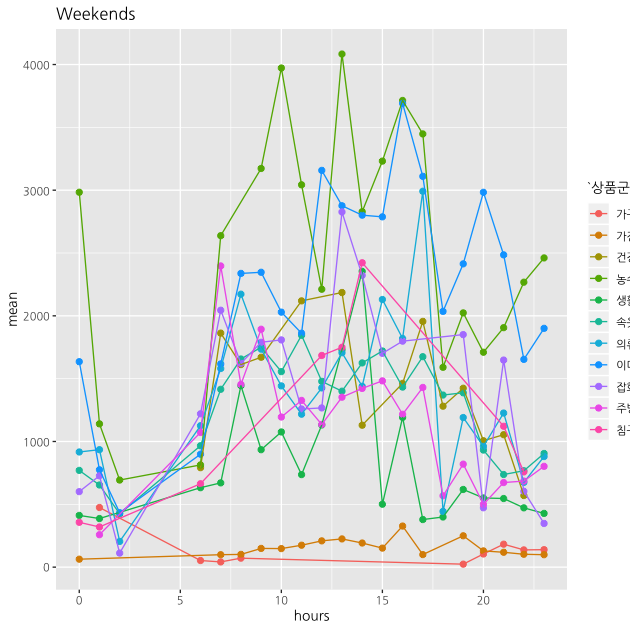

In [33]:
hshop.sales %>%
  filter(weekends == 1) %>%
  group_by(상품군, hours) %>%
  summarize(mean=sum(volume)/n_distinct(show_id)) %>%
  ggplot(aes(x=hours,y=mean,group=상품군,color=상품군)) + 
  geom_point(size=2) + 
  geom_line(size=0.5) +
  ggtitle("Weekends")

### 건강기능 품목 월별 평균 매출액 - 계절성 확인

months,상품명,상품군,상품코드,volume,취급액,show_id,mean
12,일시불 종근당건강 락토핏 생유산균골드 단하루,건강기능,201979,314.1239,23575000,2019-12-19 4,175661667
3,일시불 종근당건강 락토핏 생유산균골드 단하루,건강기능,201980,392.7515,29476000,2019-03-23 4,121121760
5,뉴트리원 다이어트 구미,건강기능,200139,663.8814,39169000,2019-05-29 20,119467950
9,정직한 농부의 석류,건강기능,201655,512.5543,30702000,2019-09-15 4,112359143
2,통째로 착즙한 루비 석류즙 84포,건강기능,202185,481.8442,37102000,2019-02-23 15,104463000
9,무농약레드비트즙 90봉,건강기능,201659,469.2982,18725000,2019-09-20 4,102271600
8,"[광동제약] 석류 100, 총 5박스",건강기능,201620,250.8011,17531000,2019-08-08 11,100096500
2,통째로 착즙한 루비 석류즙 84포,건강기능,201023,306.7013,23616000,2019-02-07 12,95809111
2,닥터 슈퍼 루테인,건강기능,200992,427.7295,25621000,2019-02-26 4,92199222
6,""" 100%리얼 착즙 석류 "", 총 4박스",건강기능,201608,324.8571,25014000,2019-06-04 11,91944250


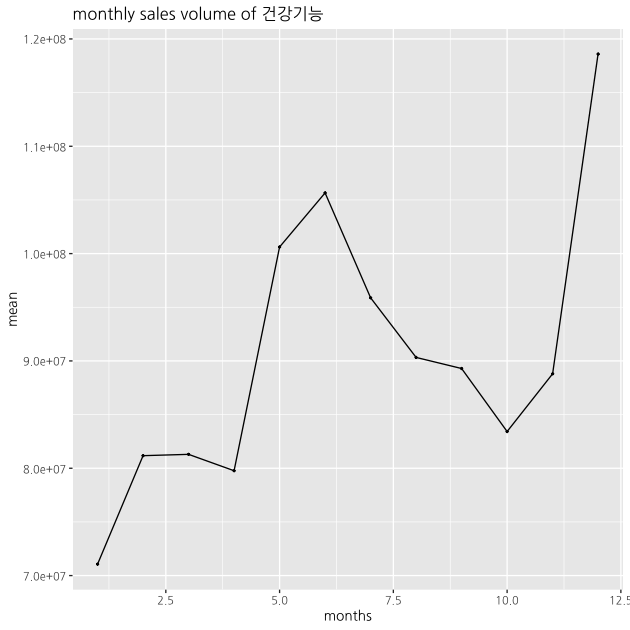

In [42]:

hshop.sales %>%
  select(months, 상품명, 상품군, volume, 취급액,show_id) %>%
  filter(상품군 == "건강기능") %>%
  group_by(months) %>%
  summarize(mean=sum(취급액)/n_distinct(show_id)) %>%
  ggplot(aes(x=months,y=mean)) + 
  geom_point(size=0.5) +
  geom_line(aes(group = 1)) +
  ggtitle("monthly sales volume of 건강기능")

# 10월 건강기능 식품 판매목록
hshop.sales %>%
  select(months, 상품명, 상품군, 상품코드, volume, 취급액,show_id) %>%
  filter((상품군 == "건강기능"))  %>%
  group_by(상품코드) %>%
  mutate(mean=sum(취급액)/n_distinct(show_id)) %>%
  arrange(desc(mean)) %>%
  filter(row_number() == 1) %>%
  head(10) 
#전반적으로 유산균, 석류즙, 루테인 판매율이 높음 - 네이버 인기 키워드와 유사

### 매출액 기준 인기상품 리스트

In [95]:
length(unique(hshop.sales$상품코드))

[1] 2031

In [113]:
hot_items <- hshop.sales %>%
  group_by(상품코드) %>%
  mutate(bp = sum(취급액)/n_distinct(show_id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(bp)) %>%
  head(40) %>%
  ungroup()

In [114]:
hot_items$상품코드

[1] "201486" "202395" "201487" "202064" "200152" "200427" "201634" "200878"
 [9] "201956" "201665" "201004" "201322" "201489" "201350" "201031" "201032"
[17] "200125" "201317" "202509" "201030" "200199" "201036" "200869" "201979"
[25] "201479" "201481" "200133" "202434" "200249" "201005" "200039" "201025"
[33] "201889" "201018" "200885" "201955" "200664" "200829" "201892" "200252"

In [115]:
unique(hot_items$상품명)

[1] "피시원 국내산 절단 햇 꽃게 2.4kg"            
 [2] "CERINI by PAT 남성 풀패키지 기모니트 3종"    
 [3] "피시원 국내산 절단 햇 꽃게 7팩"              
 [4] "고창 꿀 고구마 10kg"                         
 [5] "대동모피 19 F/W 폭스 베스트"                 
 [6] "LG전자 통돌이 세탁기 TR14WK1(화이트)"        
 [7] "완도꼬마활전복 1.3kg"                        
 [8] "셀렉프로 뚝배기 전기밥솥(멀티쿠커)"          
 [9] "램프쿡 자동회전냄비"                         
[10] "국내산 손질 햇 갑오징어 9팩"                 
[11] "코몽트 덤블 플리스 자켓 2종"                 
[12] "피시원 국내산 햇 손질문어 8팩"               
[13] "우리바다 손질왕꼬막 24팩"                    
[14] "[VONIN]보닌 남성기초세트"                    
[15] "고칼슘검은콩두유48팩+호두아몬드 두유48팩"    
[16] "코몽트 남성 이너티셔츠 7종"                  
[17] "19년 멋진밥상 흥양농협 햅쌀 20kg"            
[18] "비버리힐스폴로클럽 남성기초세트(골드+콜라겐)"
[19] "LG생활건강 샤프란아우라 고농축 섬유유연제"   
[20] "한일 대용량 스텐 분쇄믹서기"                 
[21] "일시불 종근당건강 락토핏 생유산균골드 단하루"
[22] "국내산 손질갑오징어 8팩"                     
[23] "국내산 손질갑오징어 9팩"                     
[24] "자이언트킹랍스터  (점보1미+골든 2미+ 크래커)"
[25] "참바다손질낙지100미+양념장+연포탕육수"       
[26] "(1등급)221L_딤채김치냉장고(LDL22DHWJJ)"      
[27] "김선영 정성한끼 LA갈비 6팩"                  
[28] "궁중 손질새우 200미 + 동태포 200g"           
[29] "피시원 국내산 햇 손질문어 7팩"               
[30] "푸마 언더셔츠 7종 패키지"                    
[31] "임성근의 녹용도가니탕 풀세트"                
[32] "[헤스티지] 레나 폭스퍼후드 덕다운롱코트"     
[33] "영산포숙성홍어회7팩"                         
[34] "오델로 겨울모자 3종 (2차)"                   
[35] "[K-SWISS] 19 F/W 남성 패딩 트랙수트 2종"     
[36] "푸마 에어핏 서포트 브라세트 15종+4종"        
[37] "221L_딤채김치냉장고"

In [121]:
# original_c 별 방송횟수와 비교
hshop.sales %>%
    filter(상품코드 %in% hot_items$상품코드)%>%
    group_by(original_c)  %>%
    summarise(n = n_distinct(show_id))

original_c,n
고구마,2
김치냉장고,5
꼬막,20
꽃게,10
낙지,9
남성기초,60
냄비,2
니트,1
도거니탕,2
두유,9


남성기초, 오징어는 왜 이렇게 방송을 많이 했지?
근데 많이 방송했음에도 불구하고 평균 매출액도 큰 효자상품?

In [109]:
# compare with frequently aired items
unique(hshop.sales$상품명[hshop.sales$freq == 1]) 

[1] "에코라믹 통주물 스톤 냄비세트"     "무이자 LG 통돌이 세탁기"          
[3] "일시불 LG 통돌이 세탁기"           "한일 대용량 스텐 분쇄믹서기"      
[5] "멋진밥상 흥양농협 쌀 20kg"         "AAB의 소곱창전골 800g x 8팩"      
[7] "무이자 LG전자 매직스페이스 냉장고" "일시불 LG전자 매직스페이스 냉장고"
[9] "일시불  쿠쿠전기밥솥 6인용(QS)"

In [110]:
sum(hshop.sales$취급액[hshop.sales$상품코드 %in% hot_items$상품코드])/sum(hshop.sales$취급액)*100

[1] 23.86119

실제로 인기상품이 전체 취급액에서 4.04% 담당. 

### 판매수량별 인기상품

In [123]:
#hottest items(by volume)
hot.items.amnts <- hshop.sales %>%
  group_by(상품코드) %>%
  mutate(bp_volume = sum(volume)/n_distinct(show_id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(bp_volume)) %>%
  head(40) %>%
  ungroup()

unique(hot.items.amnts$상품명)

[1] "고창 꿀 고구마 10kg"                            
 [2] "완도꼬마활전복 1.3kg"                           
 [3] "고칼슘검은콩두유48팩+호두아몬드 두유48팩"       
 [4] "LG생활건강 샤프란아우라 고농축 섬유유연제"      
 [5] "오델로 겨울모자 3종 (2차)"                      
 [6] "영산포숙성홍어회7팩"                            
 [7] "피시원 국내산 절단 햇 꽃게 2.4kg"               
 [8] "강원도양구 간편시래기15팩"                      
 [9] "피시원 국내산 절단 햇 꽃게 7팩"                 
[10] "코몽트 덤블 플리스 자켓 2종"                    
[11] "우리바다 손질왕꼬막 24팩"                       
[12] "코몽트 남성 이너티셔츠 7종"                     
[13] "비버리힐스폴로클럽 남성기초세트(골드+콜라겐)"   
[14] "시스마르스 플렉시블 웨지 펌프스"                
[15] "안동간고등어 20팩"                              
[16] "오델로 여성 겨울모자 3종"                       
[17] "국내산 손질 햇 갑오징어 9팩"                    
[18] "보코 에스닉 앙상블"                             
[19] "궁중 손질새우 200미 + 동태포 200g"              
[20] "피시원 국내산 햇 손질문어 8팩"                  
[21] "유귀열의 The 귀한 갓김치3kg+열무김치3kg, 총6kg" 
[22] "AAD 도트펀칭 컴포트 슬립온"                     
[23] "뷰티플렉스 풍기인견 원피스 2종(8월)"            
[24] "벨라홈 스마트 멀티포트 1+1 세트"                
[25] "NNF 더블페이스 쿠션재킷+베스트"                 
[26] "참바다손질낙지100미+양념장+연포탕육수"          
[27] "NNF 소프트 베스트 앙상블"                       
[28] "유귀열의 귀한 갓김치3kg+총각김치3kg (총6kg)"    
[29] "[VONIN]보닌 남성기초세트"                       
[30] "영광 生 모시떡 100개!!(동부기피70개+검정깨30개)"
[31] "NNF SS트레이닝 세트(8월)"                       
[32] "[특등급] 김천 샤인머스켓 2kg (2~3수)"           
[33] "하림뼈없는양념닭발세트"                         
[34] "현대어찬 손질갈치"                              
[35] "국내산 손질 통오징어 21미"                      
[36] "국내산참조기12팩"                               
[37] "아가타 소가죽 데이쿠션로퍼"

In [124]:
sum(hshop.sales$volume[hshop.sales$상품코드 %in% hot.items.amnts$상품코드])/sum(hshop.sales$volume)*100

[1] 19.06912

수량별 역시 식품 위주. 전체 판매수량의 19%

### Seasonal items

업데이트 예정

In [73]:
seasonal_items <- scan("seasonal_items.txt", character(), quote = "")

filtering.seasonal <- function(paras){
  
  if(paras[6] == "잡화" & paras[7] > 200000) return("명품잡화")
  else if (str_detect(paras[5], "김치냉장고")) return("김치냉장고")
  else if(str_detect(paras[5], "냉장고")) return("냉장고")
  else if(sum(str_detect(paras[5], c("에어컨","서큘레이터")))>0) return("냉방용품")
  else if(sum(str_detect(paras[5], c("공청기","공기청정기")))>0) return("공기청정기")
  else if(str_detect(paras[5], c("로보킹"))) return("청소기")
  else if(sum(str_detect(paras[5],seasonal_items)) > 0){
    return(seasonal_items[str_detect(paras[5],seasonal_items)])
  }
}



In [75]:
hshop.sales$season.item <- as.character(apply(hshop.sales,1,filtering.seasonal))
hshop.sales[hshop.sales$상품군 == "잡화" & hshop.sales$판매단가 > 200000, 14] <- "명품잡화"

### Monthly sales of seasonal items

In [13]:
hshop.sales %>%
  select(month, season.item, volume, sales) %>%
  filter(season.item != "NULL")  %>%
  group_by(season.item, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  ggplot(aes(x=month,y=mean,group=season.item,color=season.item)) + 
  geom_point(size=0.5) +
  geom_line() +
  ggtitle("monthly sales of seasonality items")


ERROR: Error in .f(.x[[i]], ...): 객체 'season.item'를 찾을 수 없습니다


3월달에 확실히 미세먼지/황사관련 공기청정기, 의류관리기 매출 비중 커지고
신학기 노트북 매출액 증가 
김치냉장고, 냉장용품은 애초에 특정시기에만 판매
명품 5-6월에 특히 증가 - 가정의 달 영향?

In [14]:

hshop.sales %>%
  select(month, season.item, volume, sales) %>%
  filter(season.item != "NULL")  %>%
  group_by(season.item, month) %>%
  summarize(mean=mean(volume, na.rm = TRUE)) %>%
  filter(season.item == "명품잡화")



ERROR: Error in .f(.x[[i]], ...): 객체 'season.item'를 찾을 수 없습니다


# 여성/남성(의류)

상품군 == 의류, 이미용, 잡화, 속옷 에서 '남성' 키워드를 포함할 경우 return 1, ow 0

In [148]:
men.category = c("의류", "이미용", "잡화", "속옷") 
hshop.sales$men <- NA
hshop.sales$men[hshop.sales$상품군 %in% men.category] <- ifelse(str_detect(hshop.sales[hshop.sales$상품군 %in% men.category,]$상품명,"남성"), 1, 0)

In [149]:
hshop.sales %>%
    group_by(men)  %>%
    summarise(mean_sales = mean(취급액))

men,mean_sales
0,23281880
1,27679957
NA,22482145


# japping time

30분 단위로 (ex. 7시 20분 방송 시작  --> 7시) 방송시간 반올림.
타방송사 인기방송 고려해서 편성되는 점 반영하고자

In [150]:
filter.jappingt <- function(x){
  time <- x[1]
  if(minute(time) < 30 & hour(time) == 0){
    return(hour(time))
  }else if(minute(time) >= 30){
    if(hour(time) == 23) return(0)
    else return(hour(time) + 1)
  }else{
    if(hour(time) == 0) return(23)
    else return(hour(time))}
}
hshop.sales$japp <- as.factor(apply(hshop.sales, 1, filter.jappingt))

ERROR: Error in as.POSIXlt.character(x, tz = tz(x)): character string is not in a standard unambiguous format


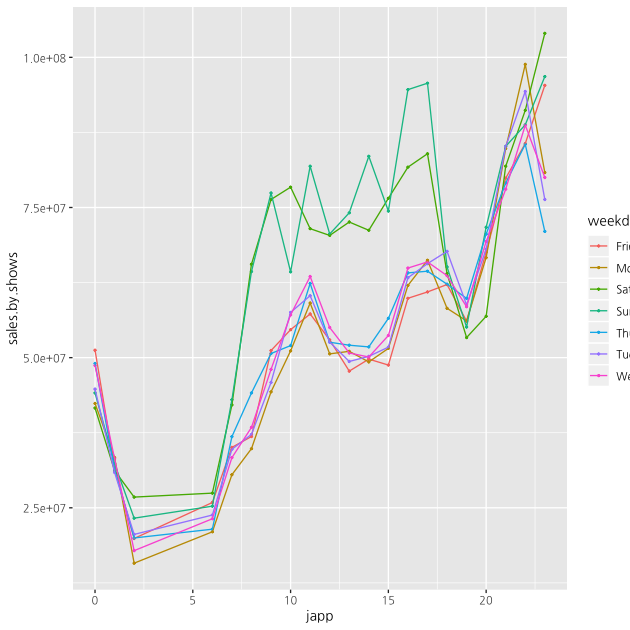

In [151]:
hshop.sales %>%
  select(japp, 취급액, weekdays,show_id) %>%
  group_by(japp, weekdays) %>%
  summarise(sales.by.shows = sum(취급액)/n_distinct(show_id)) %>%
  ggplot(aes(x=japp,y=sales.by.shows, group = weekdays, color = weekdays)) + 
  geom_point(size=0.5) +
  geom_line()

주말 19시 - 저녁먹을때/주말드라마 전에는 매출이 급격히 감소

아래 주문량 기준과 비교했을 때 peak time은 비슷하나 심야시간대 콜 수가 적은 반면 매출합이 굉장히 크다 --> 단가가 높은 제품을 판매하는 경향이 있다?

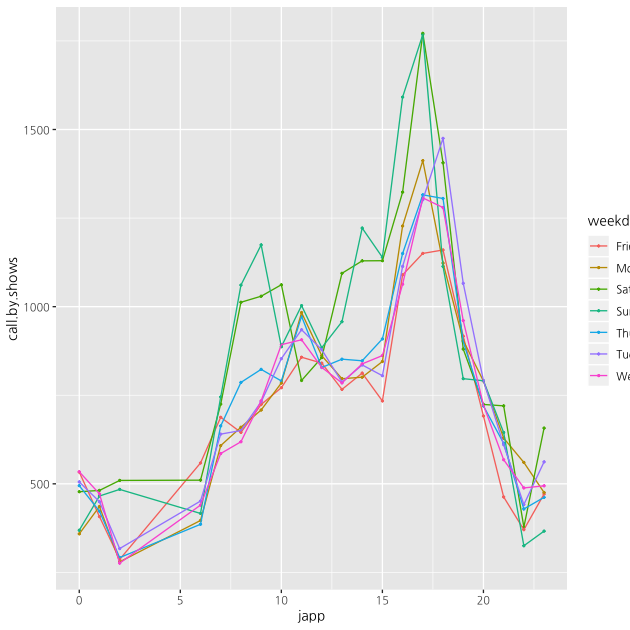

In [132]:
hshop.sales %>%
  select(japp, volume, weekdays, show_id) %>%
  group_by(japp, weekdays) %>%
  summarise(call.by.shows = sum(volume)/n_distinct(show_id)) %>%
  ggplot(aes(x=japp,y=call.by.shows, group = weekdays, color = weekdays)) + 
  geom_point(size=0.5) +
  geom_line()

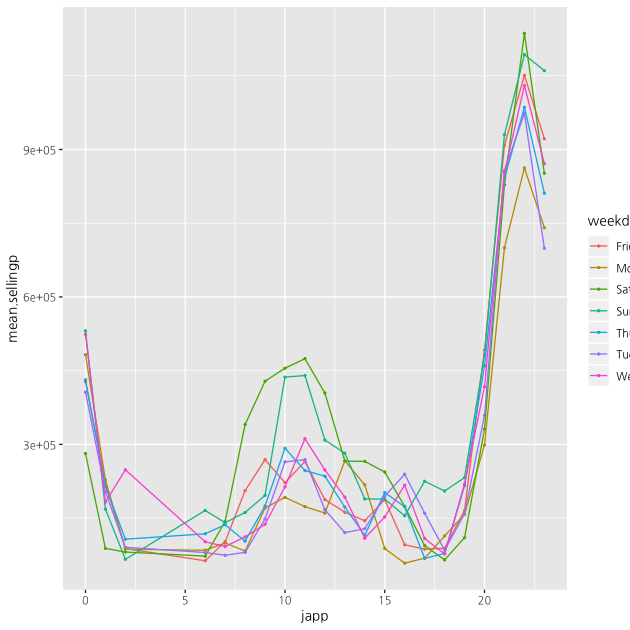

In [133]:
hshop.sales %>%
  select(japp, 판매단가, volume, weekdays, show_id) %>%
  group_by(japp, weekdays) %>%
  summarise(mean.sellingp = mean(판매단가)) %>%
  ggplot(aes(x=japp,y=mean.sellingp, group = weekdays, color = weekdays)) + 
  geom_point(size=0.5) +
  geom_line()

확실히 심야시간대 단가가 높은 제품 판매

In [167]:
colnames(hshop.sales)

[1] "index"        "방송일시"     "노출(분)"     "마더코드"     "상품코드"    
 [6] "상품명"       "상품군"       "판매단가"     "취급액"       "exposed"     
[11] "ymd"          "volume"       "years"        "months"       "days"        
[16] "hours"        "weekdays"     "hours_inweek" "holidays"     "red"         
[21] "weekends"     "min_start"    "japp"         "parttime"     "min_range"   
[26] "show_id"      "primetime"    "sales_power"  "freq"         "men"         
[31] "luxury"       "pay"          "brand"        "original_c"   "small_c"     
[36] "middle_c"     "big_c"        "hottest"

# waiting time till the next event(vol+1)

 = 방송시간(min.range)/판매수량(volume) 

낮을수록 구매가 활발히 일어남. 상품코드별 distinct

In [ ]:
hshop.sales$sales.power <- NA
for (i in unique(hshop.sales$상품코드)){
  min.dur <- hshop.sales %>%
    filter(상품코드 == i)%>%
    group_by(show.id) %>%
    filter(row_number() == 1)%>%
    ungroup()%>%
    summarise(min.dur = sum(min.range, na.rm  = TRUE))%>% as.numeric()
  
  tot.amnt <- hshop.sales %>%
    filter(상품코드 == i) %>%
    summarise(tot.sales = sum(volume, na.rm = TRUE))%>% as.numeric()
  
  hshop.sales$sales.power[hshop.sales$상품코드 == i] <- min.dur/tot.amnt
}

In [38]:
# low
hshop.sales %>%
  group_by(상품코드) %>%
  filter(row_number() == 1) %>%
  filter(is.finite(sales.power)) %>%
  arrange(desc(sales.power)) %>%
  select(상품코드,  상품명, 상품군, sales.power, 판매단가) %>%
  head(10) %>%
  as.data.frame()


상품코드,상품명,상품군,sales.power,판매단가
201559,무)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2394.0,3990000
201564,일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2154.6,3591000
201555,(일)한샘 하이바스 내추럴 하부장 + 키큰장,가구,2154.6,3591000
201556,(일)한샘 하이바스 내추럴 하부장형,가구,1992.6,3321000
201554,(일)한샘 하이바스 내추럴 기본형 + 키큰장,가구,1992.6,3321000
200536,일시불 LG 휘센 싱큐 에어컨 2IN1형 FQ19V9KWA2,가전,1475.4,2459000
201762,일시불 삼성 무풍클래식 스탠드에어컨 AF17R7573WZK,가전,843.6,2109000
200492,무이자 LG트롬 건조기 14kg RH14VN(실버),가전,756.0,1890000
200559,일시불 LG트롬 건조기 14kg RH14VN(실버),가전,720.0,1800000
200560,일시불 LG트롬 건조기 14kg RH14WN(화이트),가전,680.0,1700000


In [39]:

# high
hshop.sales %>%
  group_by(상품코드) %>%
  filter(row_number() == 1) %>%
  filter(is.finite(sales.power)) %>%
  arrange((sales.power)) %>%
  select(상품코드, 상품명, 상품군, sales.power, 판매단가) %>%
  head(10) %>%
  as.data.frame()



상품코드,상품명,상품군,sales.power,판매단가
202064,고창 꿀 고구마 10kg,농수축,0.006532835,30900
201634,완도꼬마활전복 1.3kg,농수축,0.007869326,29900
200125,고칼슘검은콩두유48팩+호두아몬드 두유48팩,농수축,0.010037787,30900
201486,피시원 국내산 절단 햇 꽃게 2.4kg,농수축,0.010304382,49900
201036,LG생활건강 샤프란아우라 고농축 섬유유연제,생활용품,0.010408158,30900
200664,오델로 겨울모자 3종 (2차),잡화,0.010960897,29800
201955,영산포숙성홍어회7팩,농수축,0.010983615,29900
201322,코몽트 덤블 플리스 자켓 2종,의류,0.011086997,39900
201487,피시원 국내산 절단 햇 꽃게 7팩,농수축,0.011092600,49900
202063,강원도양구 간편시래기15팩,농수축,0.011727942,30900


단가가 낮아야 waiting time이 확실히 감소

# freq items 

방송 횟수가 잦은 상품들. 방송횟수 기준 탑 10의 상품코드

In [184]:
freq_list <- hshop.sales %>%
  group_by(상품코드) %>%
  mutate(n.shows = n_distinct(show_id)) %>%
  filter(row_number() == 1) %>%
  arrange(desc(n.shows)) %>%
  head(40)%>%
  select(상품코드)%>%
  as.data.frame()
  
# 간고등어, 한일대용량 믹서기, 세탁기

In [185]:
hshop.sales$freq  <- NA
hshop.sales$freq <- ifelse(hshop.sales$상품코드 %in% freq_list$상품코드, 1, 0)

# 요일+시간 vs 168시간/주

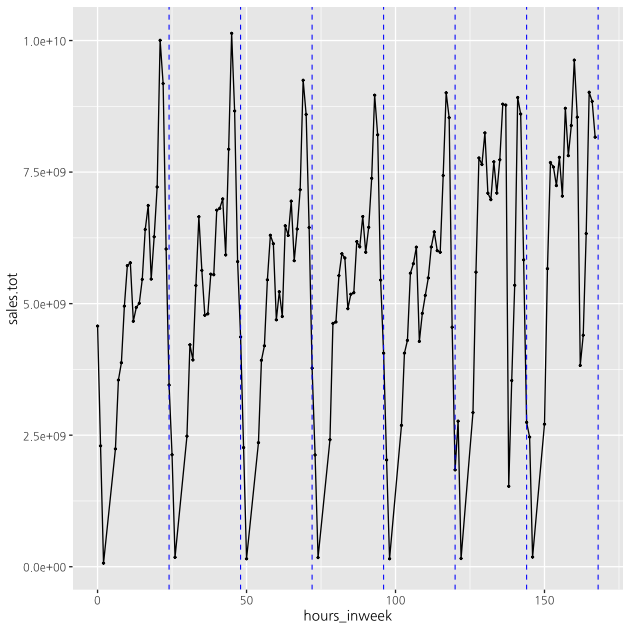

In [11]:
hshop.sales %>%
  group_by(hours_inweek) %>%
  summarise(sales.tot = sum(sales, na.rm = TRUE)) %>%
  ggplot(aes(x=hours_inweek,y=sales.tot)) + 
  geom_point(size=0.5) +
  geom_line() + 
  geom_vline(xintercept = 24*(1:7), linetype="dashed", 
                color = "blue", size=0.4)

# Data with categories

시간대별로 어떤 original_c 제품들이 많이 팔리는지?

In [192]:
hshop.sales %>%
  group_by(hours, original_c) %>%
  summarise(n = sum(취급액)) %>%
  arrange(desc(n)) %>%
  slice(1:2) %>%
  as.data.frame()

hours,original_c,n
0,속옷세트,2040581000
0,브라,1413207000
1,시계,1001883000
1,드로즈,988284000
2,속눈썹,137286000
2,자켓,102543000
6,팬츠,1251022000
6,의류세트,830007000
7,신발,1676264000
7,의류세트,1517712000


확실히 <br />
이른 아침 -- 의류 <br />
아침부터 낮 -- 잡화 및 의류? 뭔가 주부 취향 <br />
저녁 먹기 전 -- 식품 <br />
심야시간대 -- TV, 냉장고, 침대 (단가 높은 제품)

# brand power

sales_power 낮은데 단가도 높은 상품이 진짜 효자 상품아닐까?

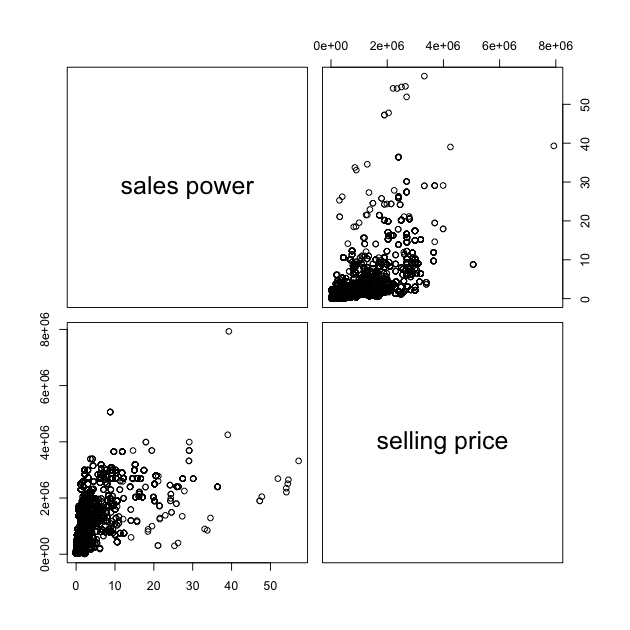

In [195]:
pairs(~ sales_power + 판매단가, hshop.sales, 
     labels = c("sales power", "selling price"))

In [196]:
colnames(hshop.sales)

[1] "index"        "방송일시"     "노출(분)"     "마더코드"     "상품코드"    
 [6] "상품명"       "상품군"       "판매단가"     "취급액"       "exposed"     
[11] "ymd"          "volume"       "years"        "months"       "days"        
[16] "hours"        "weekdays"     "hours_inweek" "holidays"     "red"         
[21] "weekends"     "min_start"    "japp"         "parttime"     "min_range"   
[26] "show_id"      "primetime"    "sales_power"  "freq"         "men"         
[31] "luxury"       "pay"          "brand"        "original_c"   "small_c"     
[36] "middle_c"     "big_c"        "hottest"

In [257]:
bpower_list <- hshop.sales %>%
    filter(quantile(sales_power, 0.7)< sales_power) %>%
    filter(quantile(판매단가, 0.7)< 판매단가)%>%
    group_by(상품코드) %>%
    mutate(show_counts = n_distinct(show_id))%>%
    filter(row_number() == 1)%>%
    select(상품코드) %>%
    as.list()

In [264]:
head(bpower_list$상품코드)

[1] "200487" "200441" "200508" "200432" "200451" "200518"

In [261]:
head(unique(hshop.sales$상품명[hshop.sales$상품코드 %in% bpower_list$상품코드]),20)

[1] "무이자 LG전자 매직스페이스 냉장고"          
 [2] "무이자 LG 울트라HD TV 65UK6800HNC"          
 [3] "일시불 LG 울트라HD TV 65UK6800HNC"          
 [4] "무이자 LG 울트라HD TV 55UK6800HNC"          
 [5] "무이자 LG 울트라HD TV 70UK7400KNA"          
 [6] "일시불 LG 울트라HD TV 70UK7400KNA"          
 [7] "무이자 삼성 UHD TV UN65NU7010FXKR"          
 [8] "일시불 삼성 UHD TV UN65NU7010FXKR"          
 [9] "무이자 삼성 UHD TV UN75NU7010FXKR"          
[10] "일시불 삼성 UHD TV UN75NU7010FXKR"          
[11] "일시불 LG 울트라HD TV 70UK6800HNC"          
[12] "무이자 LG 울트라HD TV 70UK6800HNC"          
[13] "무이자 삼성 유로피안 냉장고RS82M6000S8"     
[14] "일시불 LG 노트북 그램 15인치 15Z980-G.AR3DK"
[15] "무이자 LG 노트북 그램 15인치 15Z980-G.AR3DK"
[16] "무이자 LG 노트북 그램 15인치 15Z980-L.AR1DK"
[17] "(무)한샘 HG 화이트 실버슬림 붙박이장(4.2m)" 
[18] "(일)4인용 한샘 뉴퍼스티지R 리클라이너"      
[19] "(무)4인용 한샘 뉴퍼스티지R 리클라이너"      
[20] "일시불 LG 울트라HD TV 75UK6200KNB"